In [ ]:
!pip install scikit-multilearn
!pip install contractions

     |████████████████████████████████| 89 kB 5.6 MB/s 
     |████████████████████████████████| 287 kB 35.2 MB/s 
     |████████████████████████████████| 106 kB 45.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk.corpus
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('all')
# from nltk seaborn sklearn gensim pyldavis
from nltk.corpus import stopwords, words
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions
# wordcloud textblob spacy textstat
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset, ClassifierChain
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package 

In [ ]:
test_label = pd.read_csv("test_labels.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [ ]:
# Merging test and train to form one huge dataset
test_data = pd.merge(test, test_label)
dataset = pd.concat([test_data, train])
dataset.drop(columns=['id'], inplace=True)
dataset.drop_duplicates(inplace=True, ignore_index=True)
dataset.drop(dataset.index[dataset['toxic'] == -1], inplace = True)
dataset.reset_index(inplace = True)
dataset

,index,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,5,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,7,:Dear god this site is horrible.,0,0,0,0,0,0
2,10,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,12,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,13,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
211418,284068,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
211419,284069,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
211420,284070,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
211421,284071,And it looks like it was actually you who put ...,0,0,0,0,0,0


### Text cleaning

In [ ]:
# Text cleaning
#converting to lower case
dataset['comment_text_cleaned'] = dataset['comment_text'].str.lower()
#removing special characters
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", str(elem)))
#removing numbers
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda elem: re.sub(r"\d+", "", str(elem)))
# Removing stop words
stop = stopwords.words('english')
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
import contractions
# Replacing contractions with their full forms
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: contractions.fix(x))
#Tokenizing
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: word_tokenize(x))
#Lemmitization
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: word_lemmatizer(x))
dataset

,index,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_cleaned
0,5,Thank you for understanding. I think very high...,0,0,0,0,0,0,"[thank, understanding, think, highly, would, r..."
1,7,:Dear god this site is horrible.,0,0,0,0,0,0,"[dear, god, site, horrible]"
2,10,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,"[somebody, invariably, try, add, religion, rea..."
3,12,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,"[say, right, type, type, institution, needed, ..."
4,13,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,"[adding, new, product, list, make, sure, relev..."
...,...,...,...,...,...,...,...,...,...
211418,284068,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,"[second, time, asking, view, completely, contr..."
211419,284069,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,"[ashamed, horrible, thing, put, talk, page]"
211420,284070,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,"[spitzer, umm, there, is, actual, article, pro..."
211421,284071,And it looks like it was actually you who put ...,0,0,0,0,0,0,"[look, like, actually, put, speedy, first, ver..."


### Train test dev split

In [ ]:
# Splitting into train test sets
X = dataset.drop(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
y = dataset[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()

X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X,y, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val,y_test_and_val, train_size=0.5)

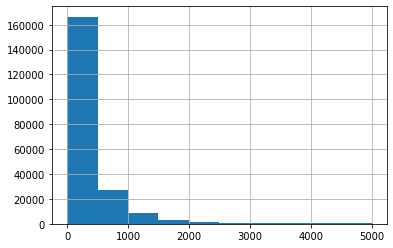

In [ ]:
dataset['comment_text'].str.len().hist()

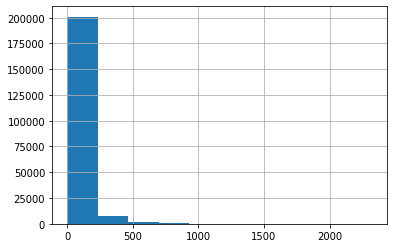

In [ ]:
dataset['comment_text'].str.split().map(lambda x: len(x)).hist()

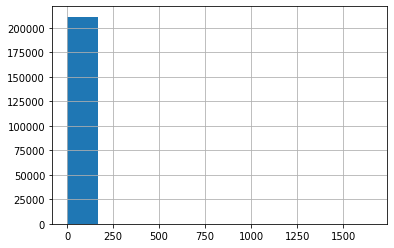

In [ ]:
dataset['comment_text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

In [ ]:
# corpus=[]
# new= dataset['comment_text'].str.split()
# new=new.values.tolist()
# corpus=[word for i in new for word in i]

# from collections import defaultdict
# dic=defaultdict(int)
# for word in corpus:
#     if word in stop:
#         dic[word]+=1

In [ ]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    print(stop)
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        # print(word)
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

# def check(dataset['comment_text'], word):


{'from', 'it', 'couldn', 'our', 'their', 'they', 'hers', 'only', 'below', 'shan', 'needn', 'doing', 'can', 'its', 'being', 'the', 'yourself', 'he', "haven't", 'wouldn', 'wasn', 'hasn', 'when', 'she', 'will', "she's", 'then', 'between', 'o', 'because', 'd', 'an', 'on', 'some', 'herself', 'now', 'which', 'off', 'as', "that'll", 'or', 'in', 'hadn', "hasn't", 'of', 'aren', 'don', 'did', 'if', 'ourselves', 'by', 'such', 'doesn', "doesn't", 'not', "mightn't", 'theirs', 'him', 'about', 'her', 'i', 'itself', 'than', 'shouldn', 'your', 'how', "you're", 'until', 'further', 'again', 'up', "aren't", 'down', 've', 'at', "didn't", 'all', 'same', 'nor', 'mightn', 'be', 'a', "won't", "mustn't", 'so', 'isn', "isn't", 'for', "don't", 'through', 'under', "weren't", 'too', 'himself', 'ma', 'here', 'any', 'most', "shouldn't", 'who', 'have', 'these', 'were', 'didn', "couldn't", 'am', 'whom', 'while', "wouldn't", 'won', "should've", 'll', 'what', 'his', 'where', 'themselves', 'haven', 't', 'y', 'had', 'but',

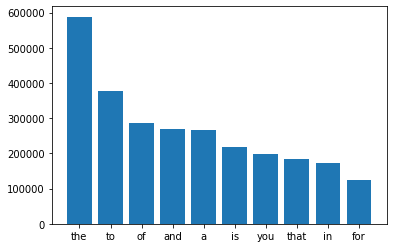

In [ ]:
plot_top_stopwords_barchart(dataset['comment_text'])

In [ ]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

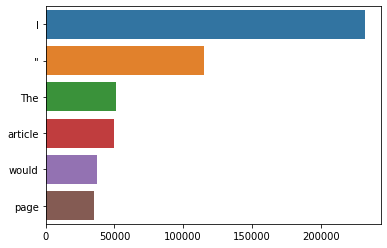

In [ ]:
plot_top_non_stopwords_barchart(dataset['comment_text'])


In [ ]:
from nltk.util import ngrams
list(ngrams(['I' ,'went','to','the','river','bank'],2))

[('I', 'went'),
 ('went', 'to'),
 ('to', 'the'),
 ('the', 'river'),
 ('river', 'bank')]

In [ ]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

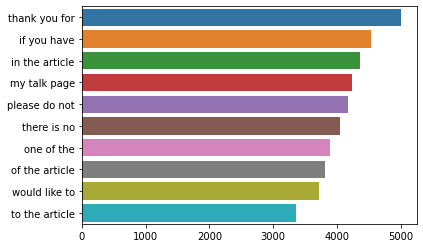

In [ ]:
top_tri_grams=get_top_ngram(dataset['comment_text'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer

def preprocess_comm(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for data in df['comment_text']:
        words=[w for w in word_tokenize(data) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_comm(dataset)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import gensim
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
# from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus,num_topics = 4, passes = 10, workers = 2)
lda_model.show_topics()

[(0,
  '0.021*"344" + 0.012*"23" + 0.009*"174" + 0.009*"331" + 0.009*"154" + 0.007*"358" + 0.007*"136" + 0.006*"909" + 0.006*"4" + 0.005*"108"'),
 (1,
  '0.035*"358" + 0.028*"110" + 0.027*"27" + 0.016*"663" + 0.014*"114" + 0.009*"475" + 0.009*"89" + 0.009*"428" + 0.008*"3774" + 0.008*"124"'),
 (2,
  '0.026*"534" + 0.012*"1351" + 0.011*"6704" + 0.009*"2649" + 0.009*"646" + 0.008*"12573" + 0.007*"34997" + 0.007*"37410" + 0.006*"11590" + 0.006*"46425"'),
 (3,
  '0.013*"27" + 0.012*"67" + 0.007*"344" + 0.006*"127" + 0.006*"7" + 0.005*"108" + 0.004*"249" + 0.004*"4" + 0.003*"395" + 0.003*"179"')]

In [ ]:
!pip install --upgrade pip

!pip install --upgrade jupyter notebook

!pip install pyLDAvis

     |████████████████████████████████| 2.1 MB 27.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.5/428.5 kB 35.5 MB/s eta 0:00:00
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: notebook
    Found existing installation: notebook 5.3.1
    Uninstalling notebook-5.3.1:
      Successfully uninstalled notebook-5.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires notebook~=5.3.0; python_version >= "3.0", but you have notebook 6.4.11 which is incompatible.
google-colab 1.0.0 require

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dic)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.148505  0.085571       1        1  50.410086
0     -0.130480  0.145841       2        1  24.963937
1     -0.118735 -0.239662       3        1  18.604855
2      0.397719  0.008249       4        1   6.021122, topic_info=           Term          Freq         Total Category  logprob  loglift
358        page  65647.000000  65647.000000  Default  30.0000  30.0000
27      article  88926.000000  88926.000000  Default  29.0000  29.0000
110   Wikipedia  47319.000000  47319.000000  Default  28.0000  28.0000
114      Please  20322.000000  20322.000000  Default  27.0000  27.0000
663        talk  32097.000000  32097.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2649       fuck   4103.911479   5805.625942   Topic4  -4.7155   2.4630
646        http   4059.106241   9548.039566   Topic4  -4.7265   1.9545
509         gay   1583.736564   2284.564153   Topic4  -5.6677   2.4435
1096        NOT   1558.380982   3425.460012   Topic4  -5.6838   2.0223
174         ...   1313.754895  25864.495638   Topic4  -5.8546  -0.1701

[279 rows x 6 columns], token_table=        Topic      Freq     Term
term                            
1665        1  0.145511      'll
1665        2  0.854366      'll
1665        3  0.000105      'll
12          1  0.131794      're
12          2  0.823291      're
...       ...       ...      ...
5269        3  0.005986  written
170         1  0.798672     year
170         2  0.201316     year
122061      2  0.999747    you.I
4343        3  0.999664     ~~~~

[404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

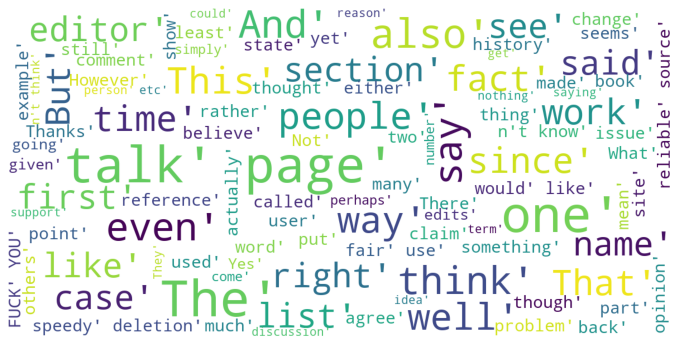

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

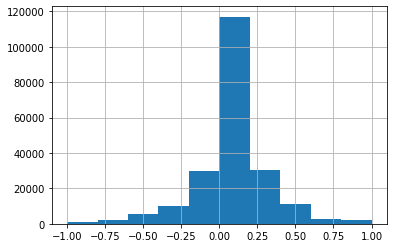

In [ ]:
from textblob import TextBlob
# TextBlob('100 people killed in Iraq').sentiment

def polarity(text):
    return TextBlob(text).sentiment.polarity

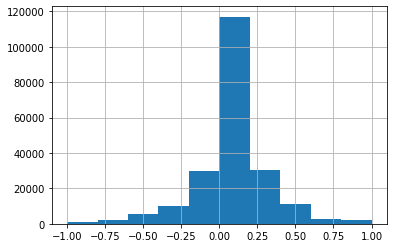

In [ ]:
dataset['polarity_score']=dataset['comment_text'].apply(lambda x : polarity(x))
dataset['polarity_score'].hist()

<BarContainer object of 3 artists>

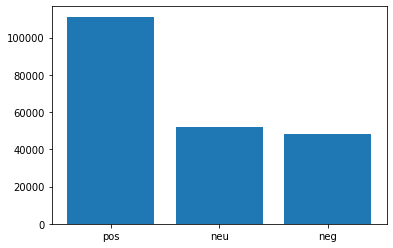

In [ ]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
dataset['polarity']=dataset['polarity_score'].map(lambda x: sentiment(x))

plt.bar(dataset.polarity.value_counts().index,dataset.polarity.value_counts())

In [ ]:
dataset[dataset['polarity']=='pos']['comment_text'].head()

0     Thank you for understanding. I think very high...
3     " \n\n It says it right there that it IS a typ...
4     " \n\n == Before adding a new product to the l...
11    . \n\n           Jews are not a race because y...
12    :::If Ollie or others think that one list of t...
Name: comment_text, dtype: object

In [ ]:
dataset[dataset['polarity']=='neg']['comment_text'].head()

1                      :Dear god this site is horrible.
2     "::: Somebody will invariably try to add Relig...
5                              this other one from 1897
18    " \n I'm not convinced that he was blind. Wher...
20    I'd never think I'd need to say it, but Wikipe...
Name: comment_text, dtype: object

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

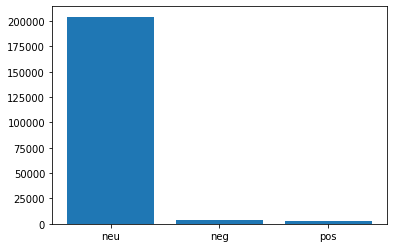

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

dataset['polarity']=dataset['comment_text'].map(lambda x: get_vader_score(x))
polarity=dataset['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index,
        polarity.value_counts())

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de026e8f-0697-4a7e-8943-78db809446af' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [ ]:
import spacy
from spacy.lang.en.examples import sentences 
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(sentences[0])
displacy.render(doc, style='ent')

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

'<div class="entities" style="line-height: 2.5; direction: ltr">\n<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Apple\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">ORG</span>\n</mark>\n is looking at buying \n<mark class="entity" style="background: #feca74; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    U.K.\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">GPE</span>\n</mark>\n startup for \n<mark class="entity" style="background: #e4e7d2; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    $1 billion\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35e

In [ ]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=dataset['comment_text'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

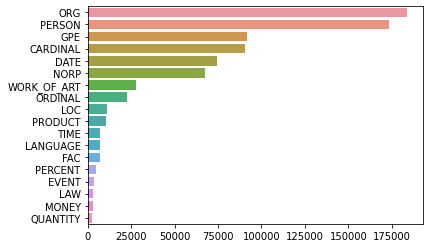

In [ ]:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

In [ ]:
def ner(text,ent="ORG"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe=dataset['comment_text'].apply(lambda x: ner(x))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

KeyboardInterrupt: ignored

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

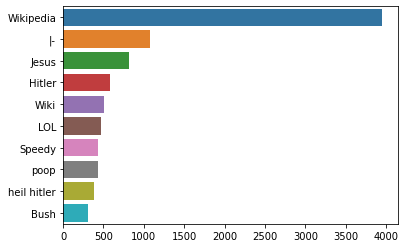

In [ ]:
per=dataset['comment_text'].apply(lambda x: ner(x,"PERSON"))
per=[i for x in per for i in x]
counter=Counter(per)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

In [ ]:
import nltk
sentence="The greatest comeback stories in 2019"
tokens=word_tokenize(sentence)
nltk.pos_tag(tokens)

In [ ]:
def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

tags=dataset['comment_text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]
counter=Counter(tags)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

In [ ]:
def get_adjs(text):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag=='NN':
            adj.append(word)
    return adj


words=dataset['comment_text'].apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]
counter=Counter(words)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

In [ ]:
from textstat import flesch_reading_ease

dataset['comment_text'].\
   apply(lambda x : flesch_reading_ease(x)).hist()

In [ ]:
x=[i for i in range(len(reading)) if reading[i]<5]
dataset.iloc[x]['comment_text'].head()